In [23]:
import akshare as ak

# 获取A股数据 - 贵州茅台
stock_zh_a_daily = ak.stock_zh_a_daily(symbol="sh600519", adjust="hfq")  # 复权数据
df = stock_zh_a_daily.sort_index()  # 按日期排序
print(df.tail())

            date      open      high       low     close     volume  \
5673  2025-05-12  13371.87  13547.01  13360.24  13426.26  2473533.0   
5674  2025-05-13  13463.25  13463.25  13264.01  13307.44  2125829.0   
5675  2025-05-14  13304.93  13765.16  13289.70  13681.40  3946012.0   
5676  2025-05-15  13679.81  13753.36  13590.52  13656.46  2473285.0   
5677  2025-05-16  13673.03  13698.13  13506.84  13506.84  2293522.0   

            amount  outstanding_share  turnover  
5673  3.967786e+09       1.256198e+09  0.001969  
5674  3.386618e+09       1.256198e+09  0.001692  
5675  6.394735e+09       1.256198e+09  0.003141  
5676  4.043403e+09       1.256198e+09  0.001969  
5677  3.714509e+09       1.256198e+09  0.001826  


In [3]:
# 检查缺失值
print(df.isnull().sum())

# 填充或删除缺失值
df = df.dropna()

# 添加每日涨跌幅
df['Daily_Return'] = df['close'].pct_change()

# 添加简单移动平均
df['SMA_20'] = df['close'].rolling(window=20).mean()
df['SMA_50'] = df['close'].rolling(window=50).mean()

date                 0
open                 0
high                 0
low                  0
close                0
volume               0
amount               0
outstanding_share    0
turnover             0
dtype: int64


In [4]:
# 基本统计信息
print(df.describe())

# 波动性分析
print(f"年度波动率: {df['Daily_Return'].std() * (252 ** 0.5):.2%}")

# 相关性分析 (如果有多个股票)
# correlation = df[['Close_Stock1', 'Close_Stock2']].corr()

               open          high           low         close        volume  \
count   5678.000000   5678.000000   5678.000000   5678.000000  5.678000e+03   
mean    4174.976772   4226.944362   4127.707557   4177.638734  2.915530e+06   
std     5338.794966   5400.923459   5279.386523   5339.350912  2.316722e+06   
min       25.910000     26.040000     25.680000     25.890000  2.381000e+04   
25%      539.452500    548.900000    533.495000    542.390000  1.482412e+06   
50%     1065.545000   1081.090000   1053.900000   1067.190000  2.560940e+06   
75%     7232.397500   7311.170000   7149.237500   7232.645000  3.791455e+06   
max    19683.620000  19987.090000  18900.380000  19782.650000  4.063180e+07   

             amount  outstanding_share     turnover  Daily_Return  \
count  5.678000e+03       5.678000e+03  5678.000000   5677.000000   
mean   1.940006e+09       8.639951e+08     0.004591      0.001250   
std    2.719014e+09       4.631635e+08     0.009364      0.020243   
min    1.421

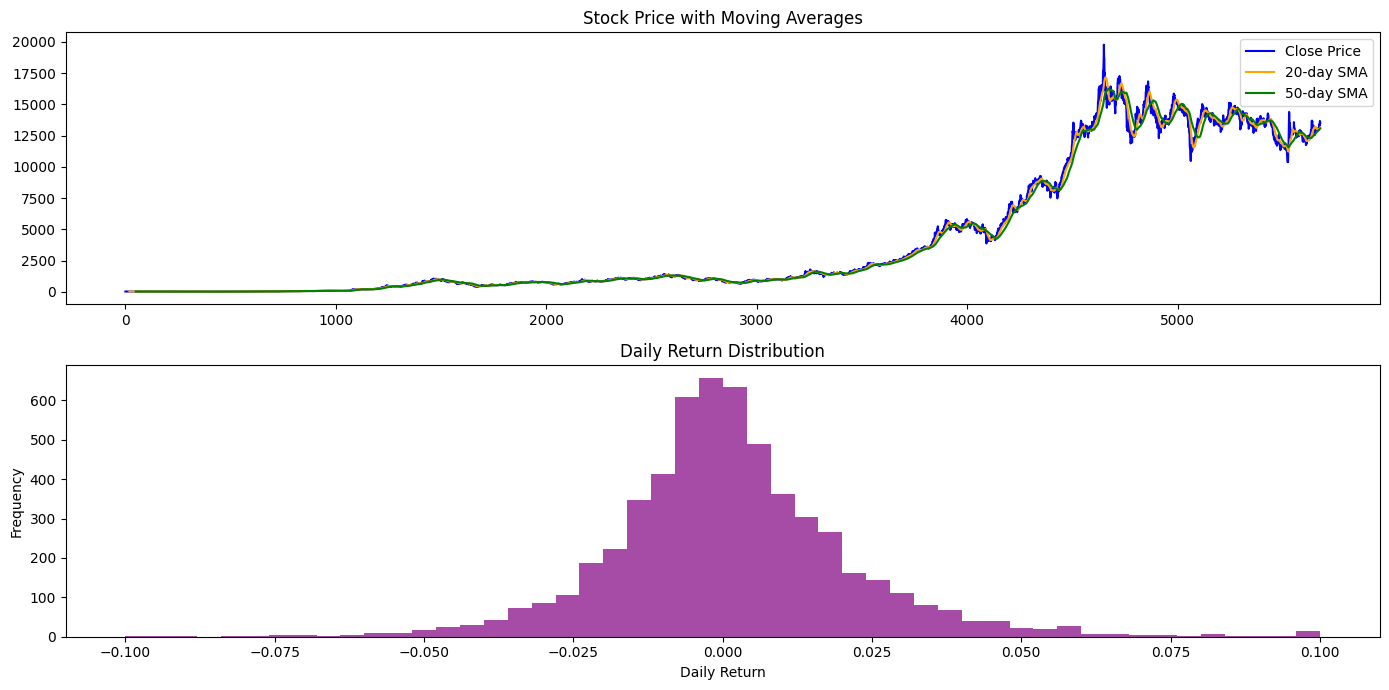

In [7]:
import matplotlib.pyplot as plt
import os

# 创建img目录如果不存在
os.makedirs('img', exist_ok=True)

# 设置画布
plt.figure(figsize=(14, 7))

# 股价走势
plt.subplot(2, 1, 1)
plt.plot(df['close'], label='Close Price', color='blue')
plt.plot(df['SMA_20'], label='20-day SMA', color='orange')
plt.plot(df['SMA_50'], label='50-day SMA', color='green')
plt.title(f'Stock Price with Moving Averages')
plt.legend()

# 每日收益率分布
plt.subplot(2, 1, 2)
plt.hist(df['Daily_Return'].dropna(), bins=50, color='purple', alpha=0.7)
plt.title('Daily Return Distribution')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')

plt.tight_layout()

# 保存图片到img目录下
plt.savefig('img/stock_analysis.png')
plt.show()


In [8]:
# RSI指标
def compute_rsi(data, window=14):
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI'] = compute_rsi(df)

In [12]:

# MACD指标
def compute_macd(data, short_window=12, long_window=26, signal_window=9):
    data['EMA_short'] = data['close'].ewm(span=short_window, adjust=False).mean()
    data['EMA_long'] = data['close'].ewm(span=long_window, adjust=False).mean()
    data['MACD'] = data['EMA_short'] - data['EMA_long']
    data['Signal_MACD'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
    data['MACD_Histogram'] = data['MACD'] - data['Signal_MACD']
    return data

df = compute_macd(df)

# 布林带指标
def compute_bollinger_bands(data, window=20, num_std=2):
    data['Rolling_Mean'] = data['close'].rolling(window=window).mean()
    data['Rolling_Std'] = data['close'].rolling(window=window).std()
    data['Upper_Band'] = data['Rolling_Mean'] + (data['Rolling_Std'] * num_std)
    data['Lower_Band'] = data['Rolling_Mean'] - (data['Rolling_Std'] * num_std)
    return data

df = compute_bollinger_bands(df)

In [19]:
# 简单均线交叉策略 **Simple Moving Average Crossover Strategy**
df['Signal'] = 0
df.loc[df['SMA_20'] > df['SMA_50'], 'Signal'] = 1
df.loc[df['SMA_20'] < df['SMA_50'], 'Signal'] = -1

# 计算策略收益
df['SMACS_Strategy_Return'] = df['Signal'].shift(1) * df['Daily_Return']

Accuracy: 53.02%
              precision    recall  f1-score   support

           0       0.51      0.57      0.54       545
           1       0.55      0.50      0.52       581

    accuracy                           0.53      1126
   macro avg       0.53      0.53      0.53      1126
weighted avg       0.53      0.53      0.53      1126



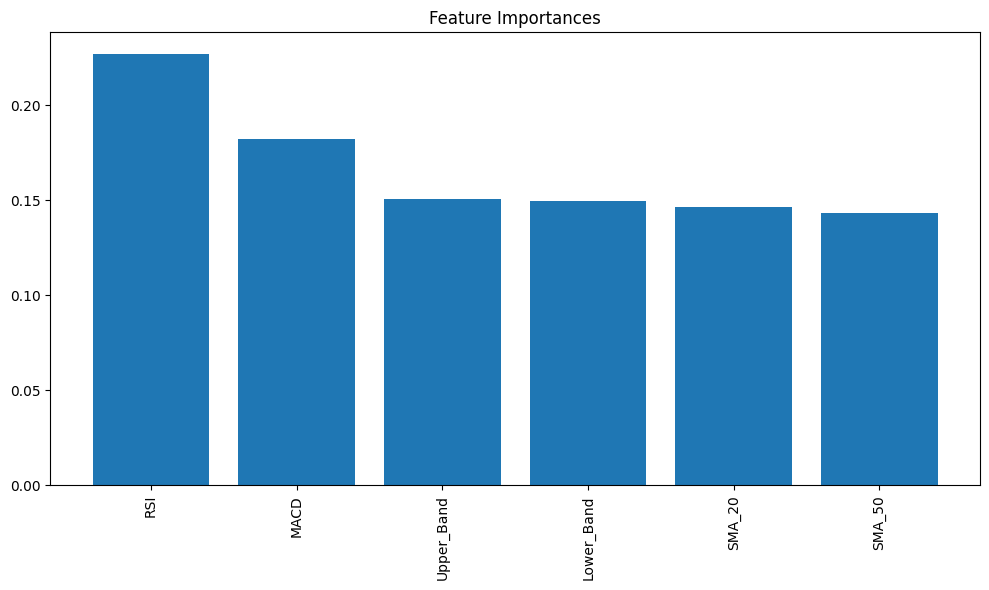

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 选择特征列和目标变量
features = ['RSI', 'MACD', 'Upper_Band', 'Lower_Band', 'SMA_20', 'SMA_50']
df['Target'] = (df['Daily_Return'] > 0).astype(int)  # 目标：预测价格是否上涨

# 删除含有缺失值的行
df = df.dropna()

# 划分训练集和测试集
X = df[features]
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化并训练随机森林分类器
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 预测并评估模型性能
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(classification_report(y_test, y_pred))

# 可视化特征重要性
import matplotlib.pyplot as plt
import numpy as np

feature_importances = model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

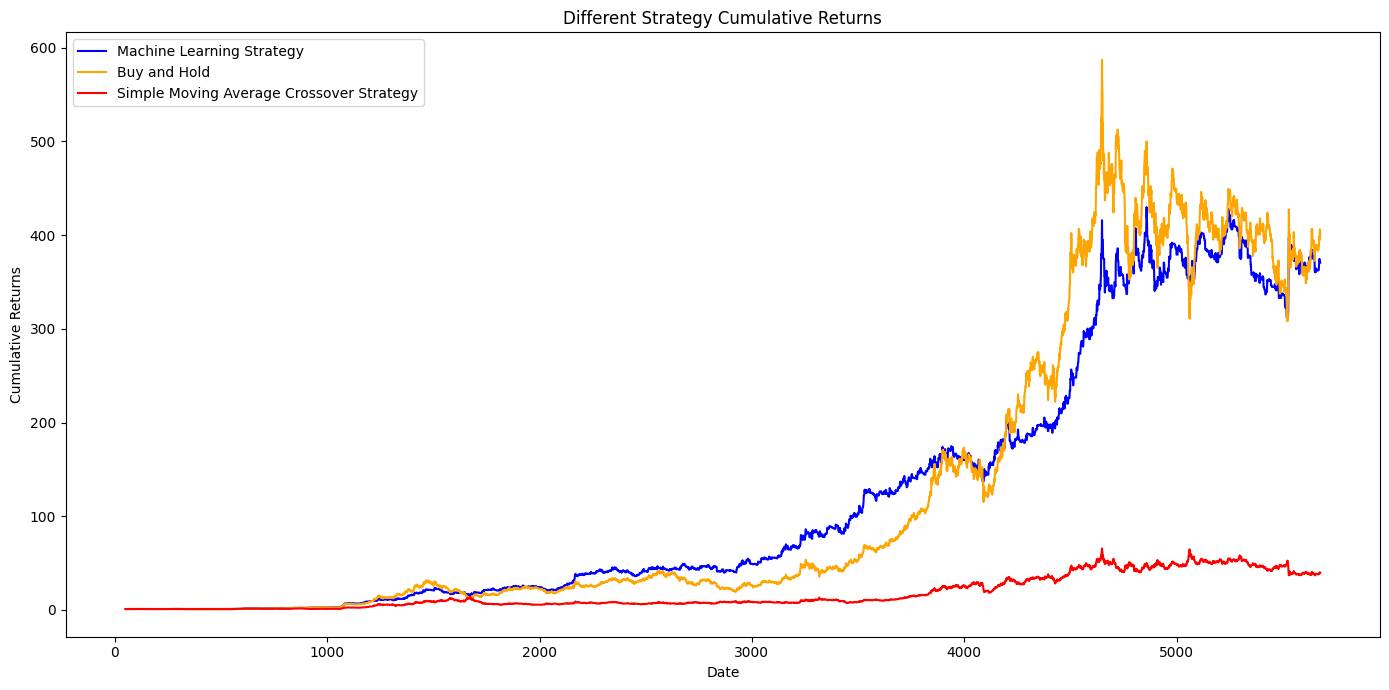

In [22]:
# 生成交易信号并计算策略收益
df['ML_Signal'] = model.predict(X)
df['ML_Strategy_Return'] = df['ML_Signal'].shift(1) * df['Daily_Return']

# 计算累计收益
df['ML_Cumulative_Return'] = (1 + df['ML_Strategy_Return']).cumprod()
df['Buy_and_Hold_Return'] = (1 + df['Daily_Return']).cumprod()
df['SMACS_Cumulative_Return'] = (1 + df['SMACS_Strategy_Return']).cumprod()

# 绘制累计收益对比图
plt.figure(figsize=(14, 7))
plt.plot(df['ML_Cumulative_Return'], label='Machine Learning Strategy', color='blue')
plt.plot(df['Buy_and_Hold_Return'], label='Buy and Hold', color='orange')
plt.plot(df['SMACS_Cumulative_Return'], label='Simple Moving Average Crossover Strategy', color='red')

plt.title('Different Strategy Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.tight_layout()

# 保存图片到img目录下
plt.savefig('img/Different_Strategy_CumulativeReturns.png')
plt.show()




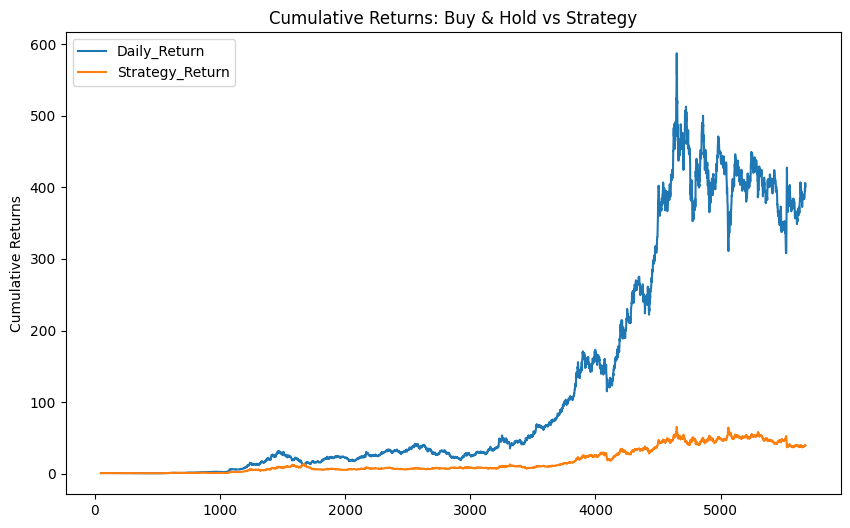